In [17]:
import pandas as pd

# Load datasets
stocks_etfs = pd.read_csv('/content/all_stocks_and_etfs.csv')
stock_descriptions = pd.read_csv('/content/stock_descriptions.csv')

# Data cleaning steps
## Convert 'Date-Time' to datetime format for easier manipulation
stocks_etfs['Date-Time'] = pd.to_datetime(stocks_etfs['Date-Time'])

## Ensure ticker symbols are of the same type and case (if needed)
stocks_etfs['Ticker_Symbol'] = stocks_etfs['Ticker_Symbol'].str.upper()
stock_descriptions['Symbol'] = stock_descriptions['Symbol'].str.upper()

## Handling missing values or anomalies if any (simple example)
stocks_etfs.fillna(method='ffill', inplace=True) # Forward fill for missing values
stock_descriptions.dropna(inplace=True) # Drop rows with missing values

# Merging datasets
## Rename the 'Symbol' column in stock_descriptions to match 'Ticker Symbol' in stocks_etfs
stock_descriptions.rename(columns={'Symbol': 'Ticker_Symbol'}, inplace=True)

## Merge on 'Ticker Symbol'
merged_data = pd.merge(stocks_etfs, stock_descriptions, on='Ticker_Symbol')

# General insights
print("Number of rows in the merged dataset:", merged_data.shape[0])
print("Number of unique ticker symbols:", merged_data['Ticker_Symbol'].nunique())
print("Date range:", merged_data['Date-Time'].min(), "to", merged_data['Date-Time'].max())

# Additional insights can be explored as needed, such as:
# - The stock with the highest trading volume
# - The ETF with the largest range between high and low prices
# - Trends in a specific sector over time

# Example: Find the stock with the highest average volume
high_vol_stock = merged_data.groupby('Ticker_Symbol')['Volume'].mean().idxmax()
print(f"The stock with the highest average trading volume is: {high_vol_stock}")

# Save the merged data to a new CSV file if needed
merged_data.to_csv('/content/merged_stocks_etfs_with_descriptions.csv', index=False)


Number of rows in the merged dataset: 144558
Number of unique ticker symbols: 28
Date range: 1999-11-01 00:00:00 to 2024-02-01 00:00:00
The stock with the highest average trading volume is: SPY


In [18]:
merged_data = pd.read_csv('/content/merged_stocks_etfs_with_descriptions.csv')

In [19]:
# Check for missing values in the merged DataFrame
missing_values = merged_data.isnull().sum()

# Print out the count of missing values per column
print("Missing values per column:")
print(missing_values)

# Check if there are any missing values in the DataFrame
total_missing = missing_values.sum()
if total_missing > 0:
    print(f"\nTotal missing values in the DataFrame: {total_missing}")
    print("\nColumns with missing values and their count:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found in the DataFrame.")


Missing values per column:
Date-Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Ticker_Symbol    0
AssetType        0
Name             0
Description      0
Sector           0
Industry         0
dtype: int64

No missing values found in the DataFrame.


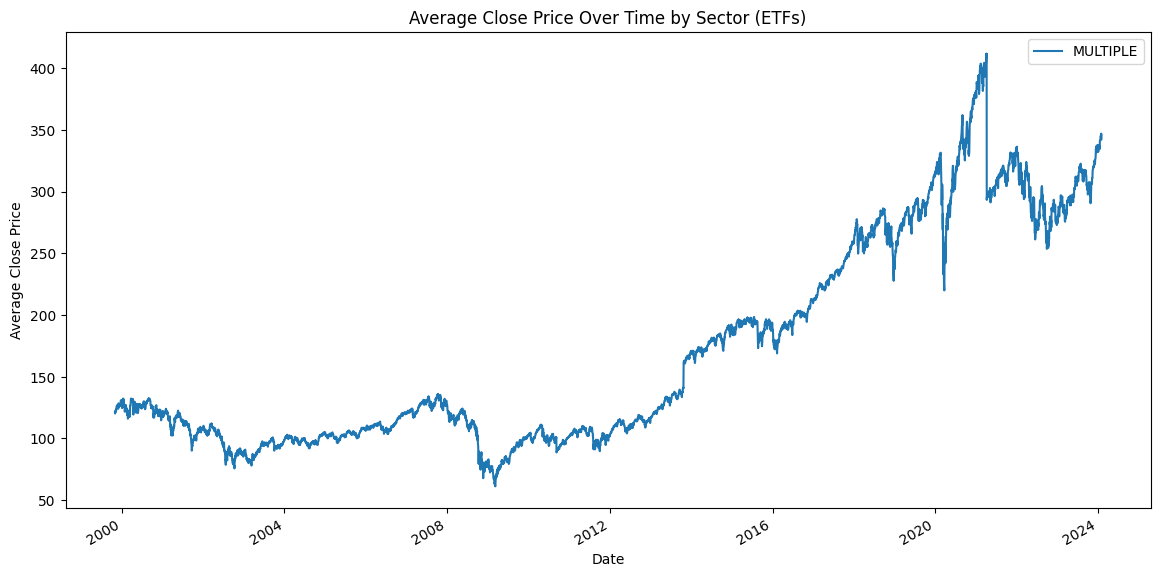

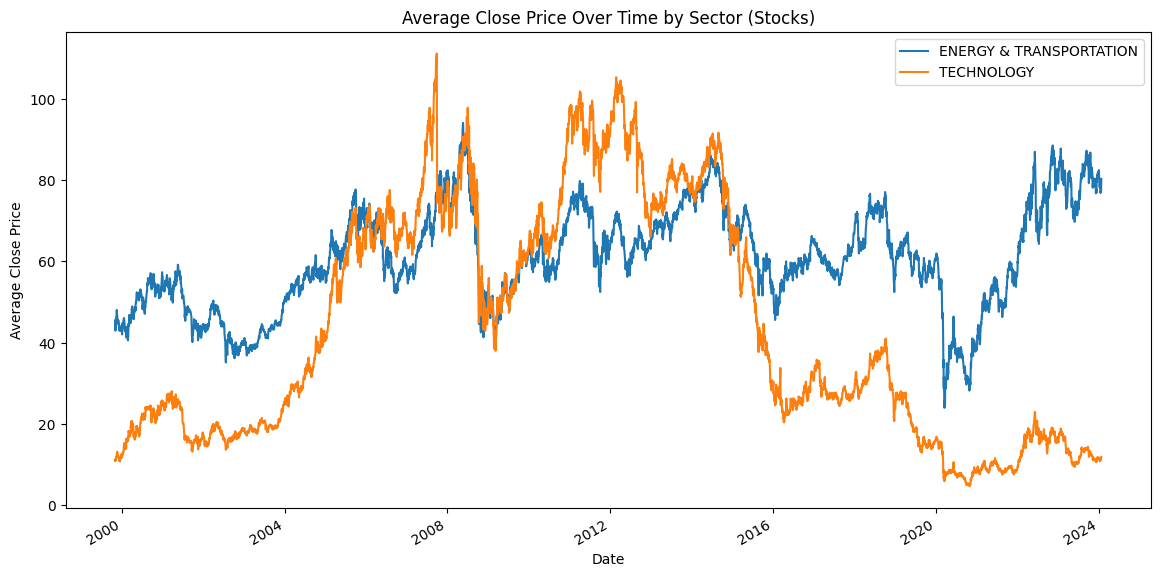

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_data' is your DataFrame and it's already loaded

# Convert 'Date-Time' to datetime format, if not already done
merged_data['Date-Time'] = pd.to_datetime(merged_data['Date-Time'])

# Ensure numeric columns are treated as such
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Filter out 'Multiple' values in Sector and Industry, and separate ETFs
#filtered_data = merged_data[(merged_data['Sector'] != 'Multiple') & (merged_data['Industry'] != 'Multiple')]
etf_data = merged_data[merged_data['AssetType'] == 'ETF']
stock_data = merged_data[merged_data['AssetType'] != 'ETF']

# Function to plot trends, adjust as necessary for specific analyses
def plot_trends(data, title_suffix):
    plt.figure(figsize=(14, 7))
    sectors = data['Sector'].unique()
    for sector in sectors:
        sector_data = data[data['Sector'] == sector]
        sector_data.groupby('Date-Time')['Close'].mean().plot(label=sector)
    plt.title(f'Average Close Price Over Time by Sector ({title_suffix})')
    plt.xlabel('Date')
    plt.ylabel('Average Close Price')
    plt.legend()
    plt.show()

# Plot trends for ETFs and Stocks separately
plot_trends(etf_data, 'ETFs')
plot_trends(stock_data, 'Stocks')

# Additional analyses like Volume and Volatility can follow similar patterns,
# separating ETFs and Stocks, and ensuring to work only with numeric data.


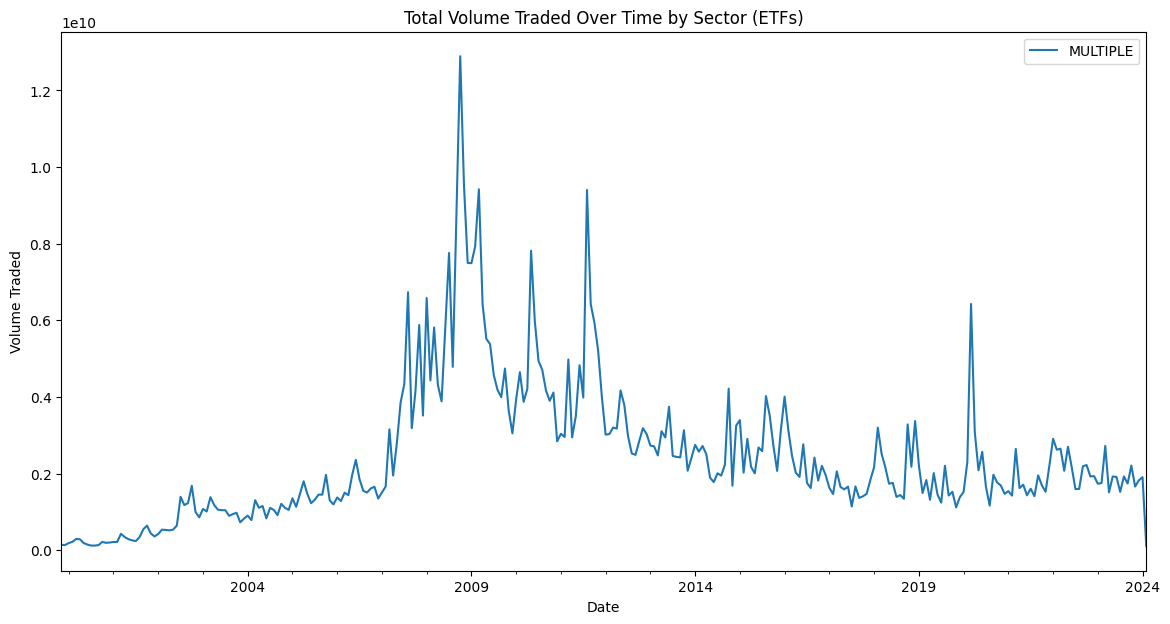

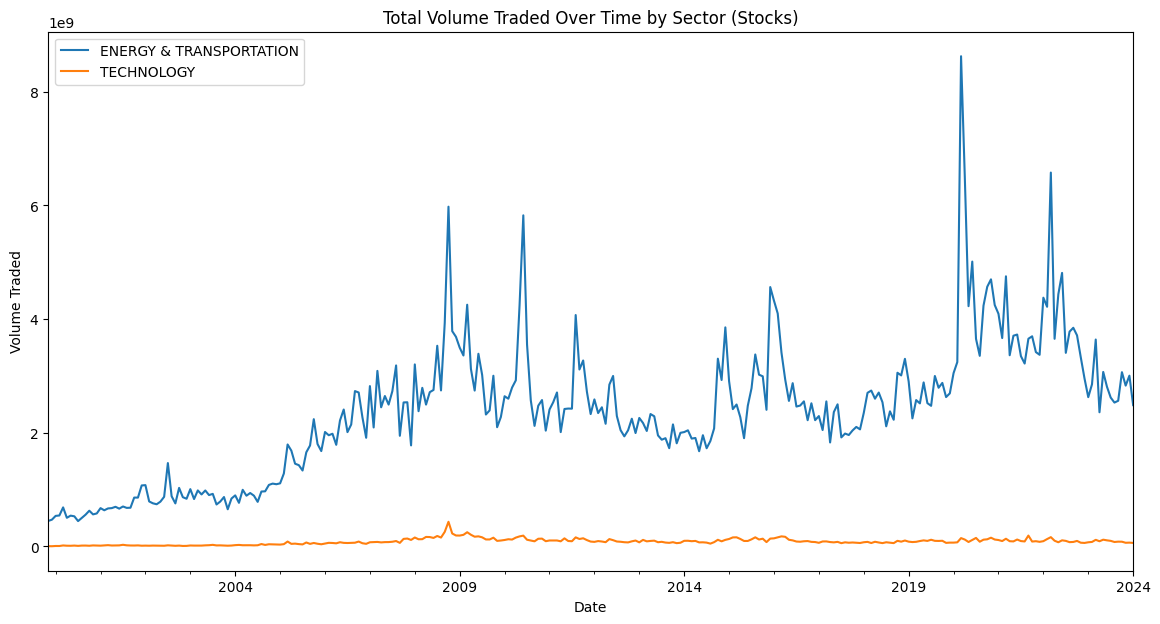

In [33]:
def plot_volume_trends(data, title_suffix):
    plt.figure(figsize=(14, 7))
    sectors = data['Sector'].unique()
    for sector in sectors:
        sector_data = data[data['Sector'] == sector]
        sector_data.resample('M', on='Date-Time').sum()['Volume'].plot(label=sector)
    plt.title(f'Total Volume Traded Over Time by Sector ({title_suffix})')
    plt.xlabel('Date')
    plt.ylabel('Volume Traded')
    plt.legend()
    plt.show()

# Plot volume trends for ETFs and Stocks
plot_volume_trends(etf_data, 'ETFs')
plot_volume_trends(stock_data, 'Stocks')


<ipython-input-34-5adcfea8dc37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Daily Change'] = data['Close'] - data['Open']


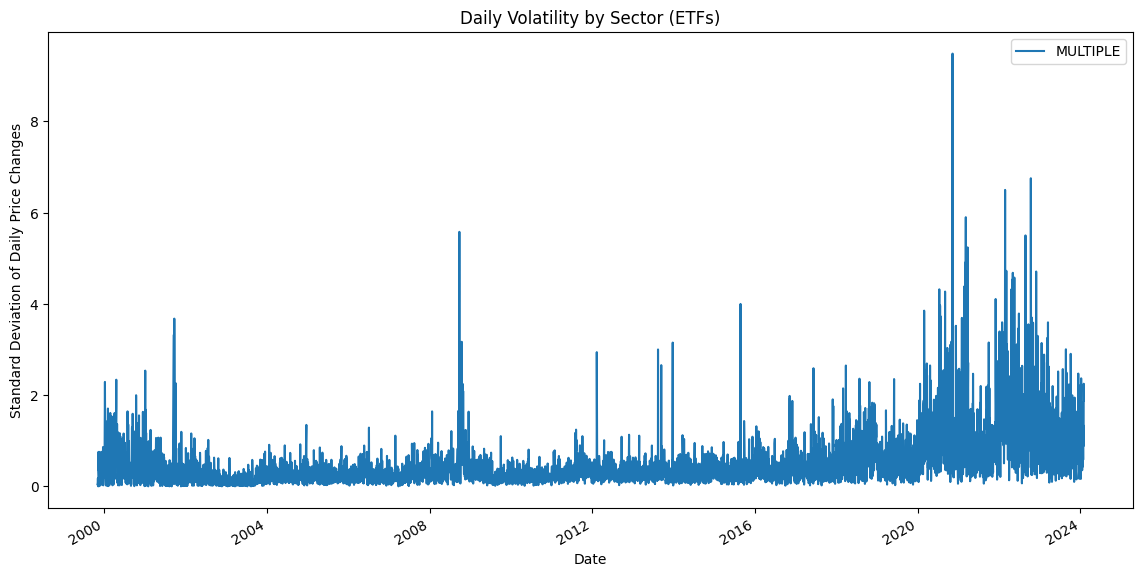

<ipython-input-34-5adcfea8dc37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Daily Change'] = data['Close'] - data['Open']


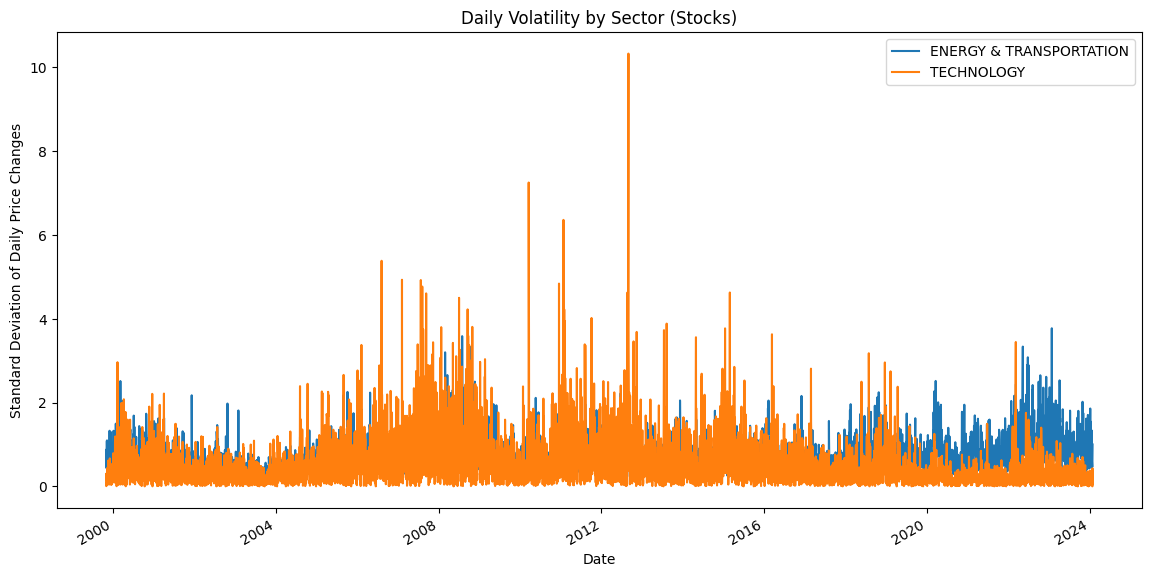

In [34]:
def calculate_and_plot_volatility(data, title_suffix):
    data['Daily Change'] = data['Close'] - data['Open']
    plt.figure(figsize=(14, 7))
    sectors = data['Sector'].unique()
    for sector in sectors:
        sector_data = data[data['Sector'] == sector]
        daily_volatility = sector_data.groupby('Date-Time')['Daily Change'].std()
        daily_volatility.plot(label=sector)
    plt.title(f'Daily Volatility by Sector ({title_suffix})')
    plt.xlabel('Date')
    plt.ylabel('Standard Deviation of Daily Price Changes')
    plt.legend()
    plt.show()

# Calculate and plot volatility for ETFs and Stocks
calculate_and_plot_volatility(etf_data, 'ETFs')
calculate_and_plot_volatility(stock_data, 'Stocks')


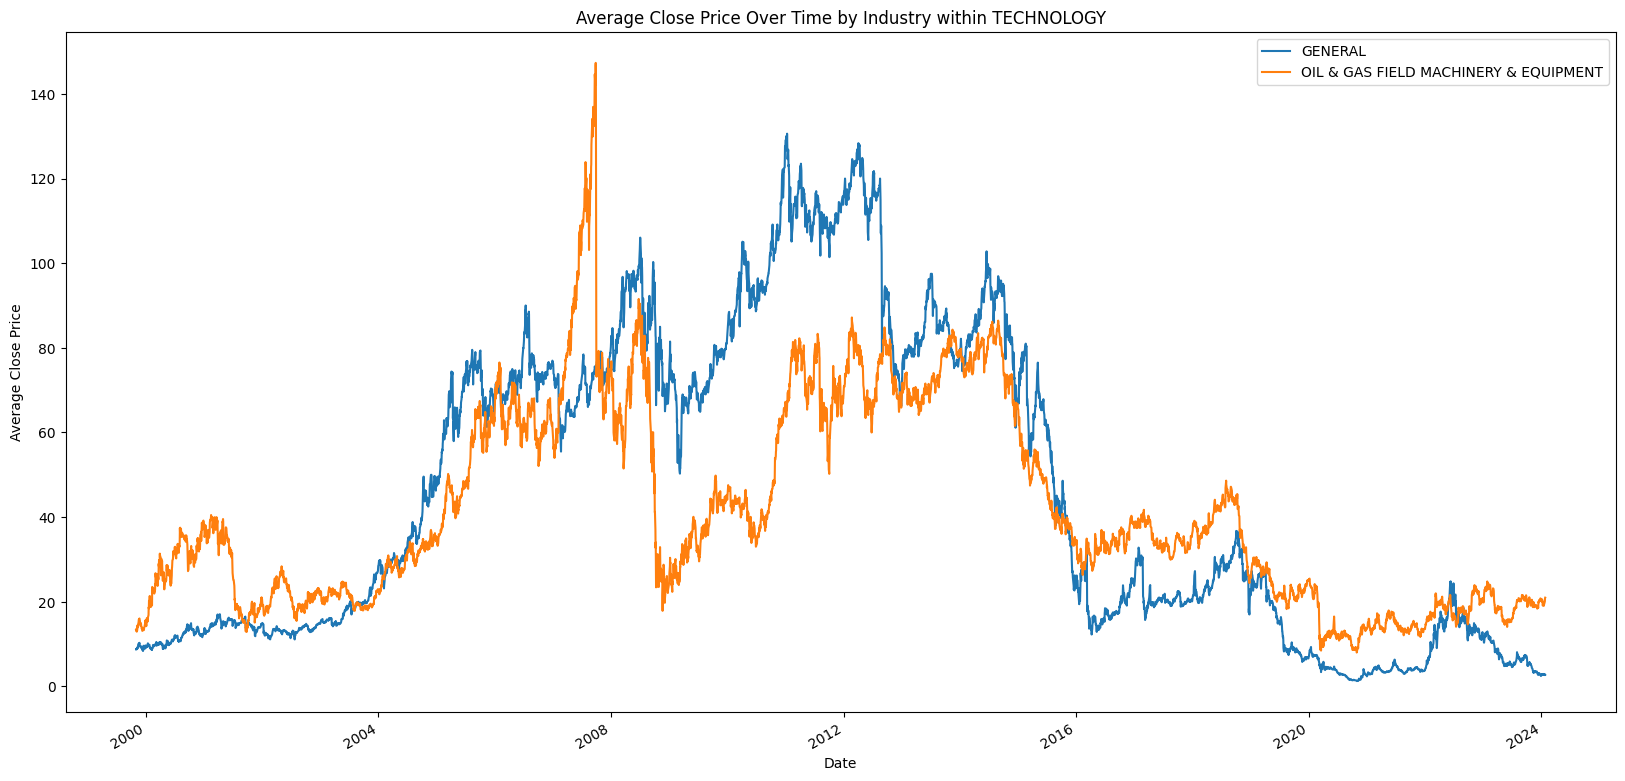

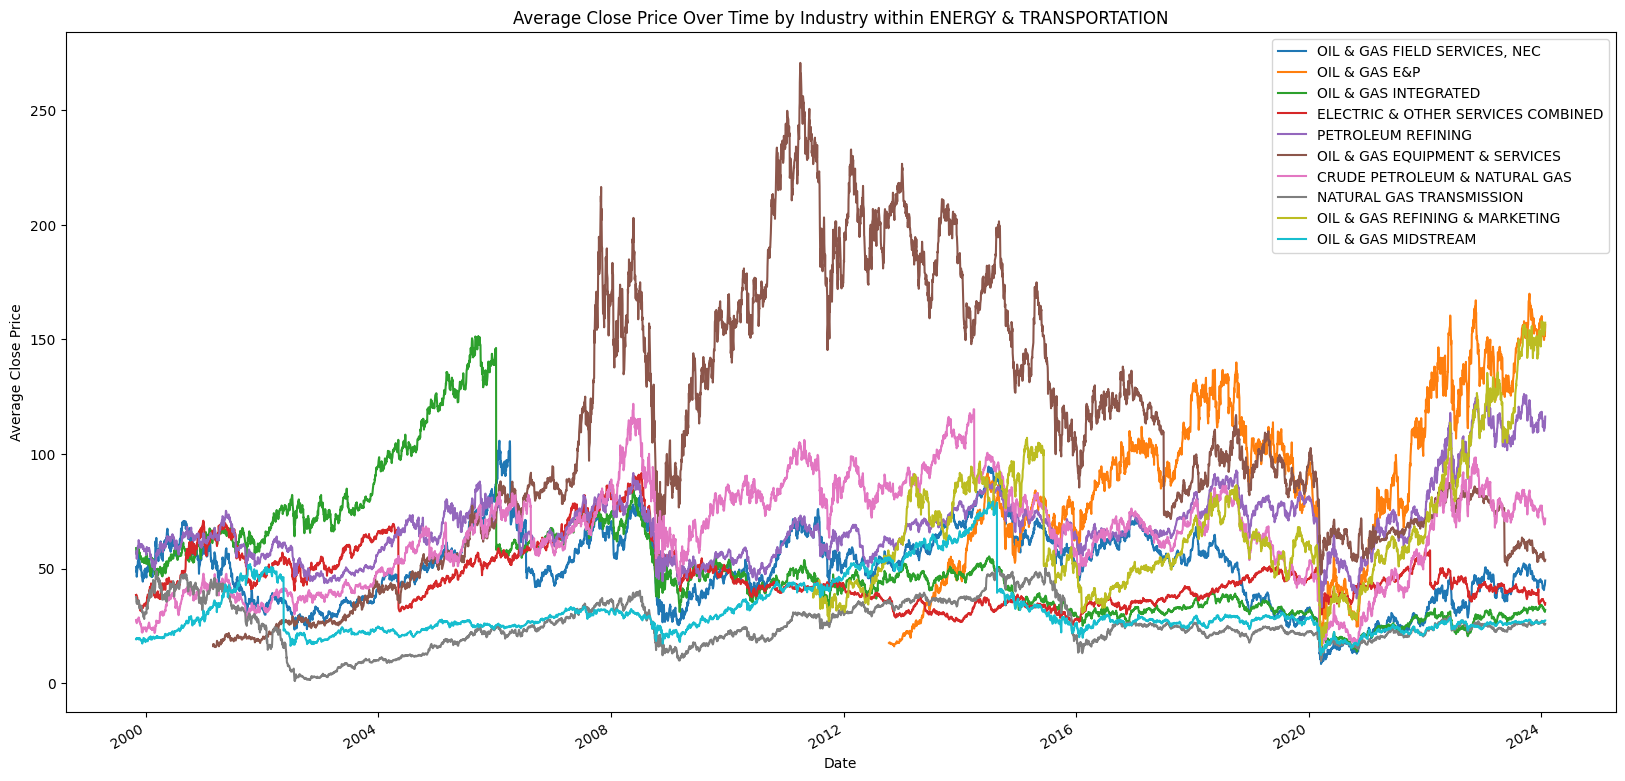

In [37]:
def plot_industry_trends_within_sector(data, sector_name):
    plt.figure(figsize=(20, 10))
    industry_data = data[data['Sector'] == sector_name]
    industries = industry_data['Industry'].unique()
    for industry in industries:
        industry_data_specific = industry_data[industry_data['Industry'] == industry]
        industry_data_specific.groupby('Date-Time')['Close'].mean().plot(label=industry)
    plt.title(f'Average Close Price Over Time by Industry within {sector_name}')
    plt.xlabel('Date')
    plt.ylabel('Average Close Price')
    plt.legend()
    plt.show()

# Example usage for a sector named 'Energy'
plot_industry_trends_within_sector(stock_data, 'TECHNOLOGY')
plot_industry_trends_within_sector(stock_data, 'ENERGY & TRANSPORTATION')


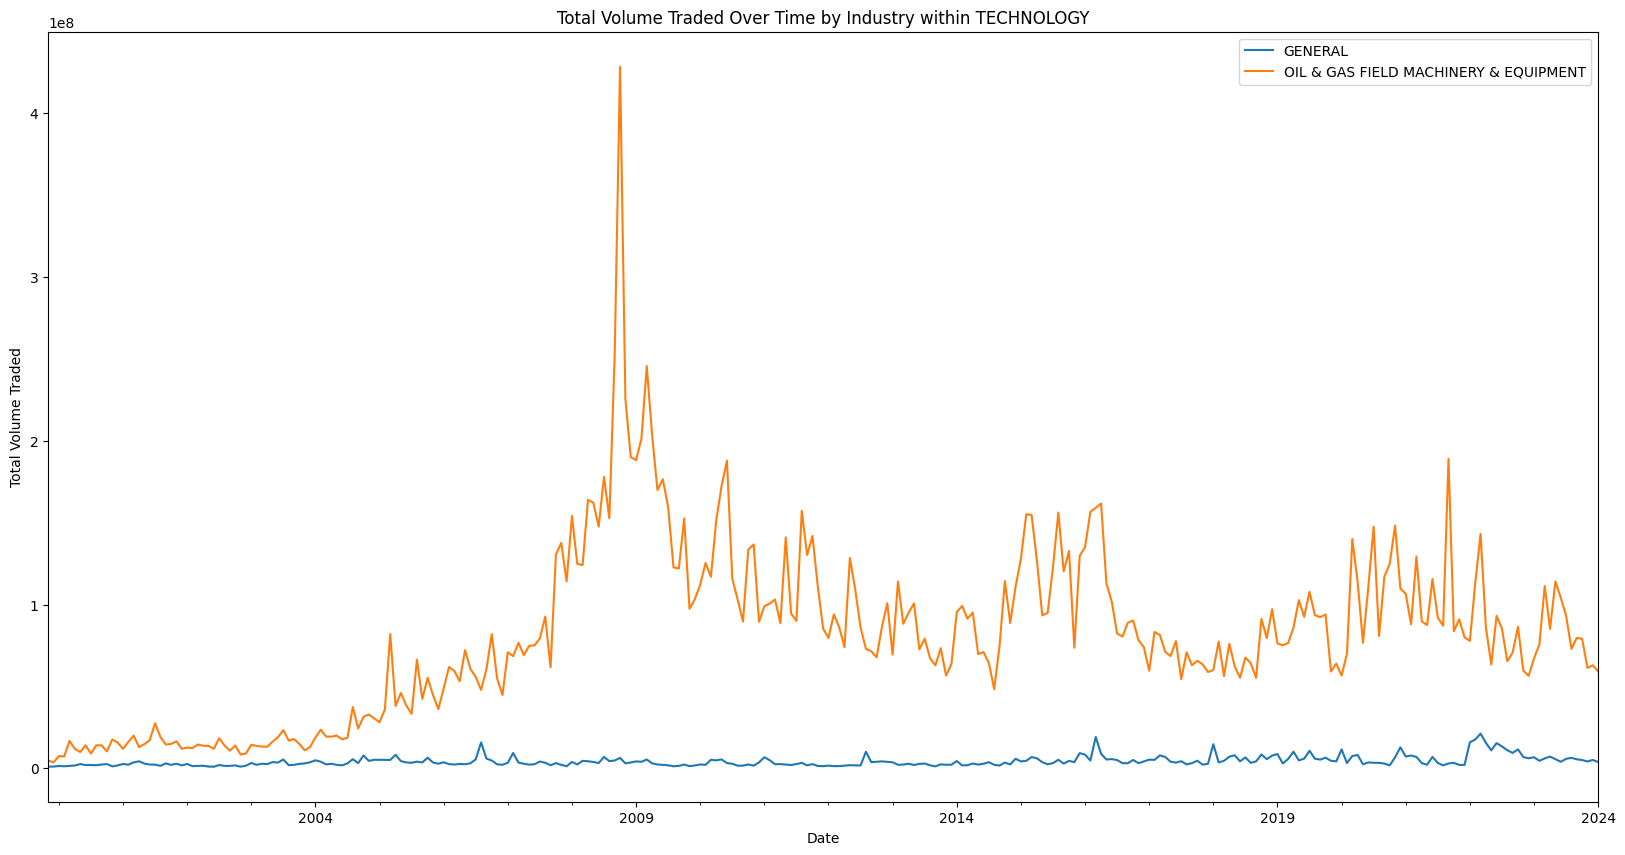

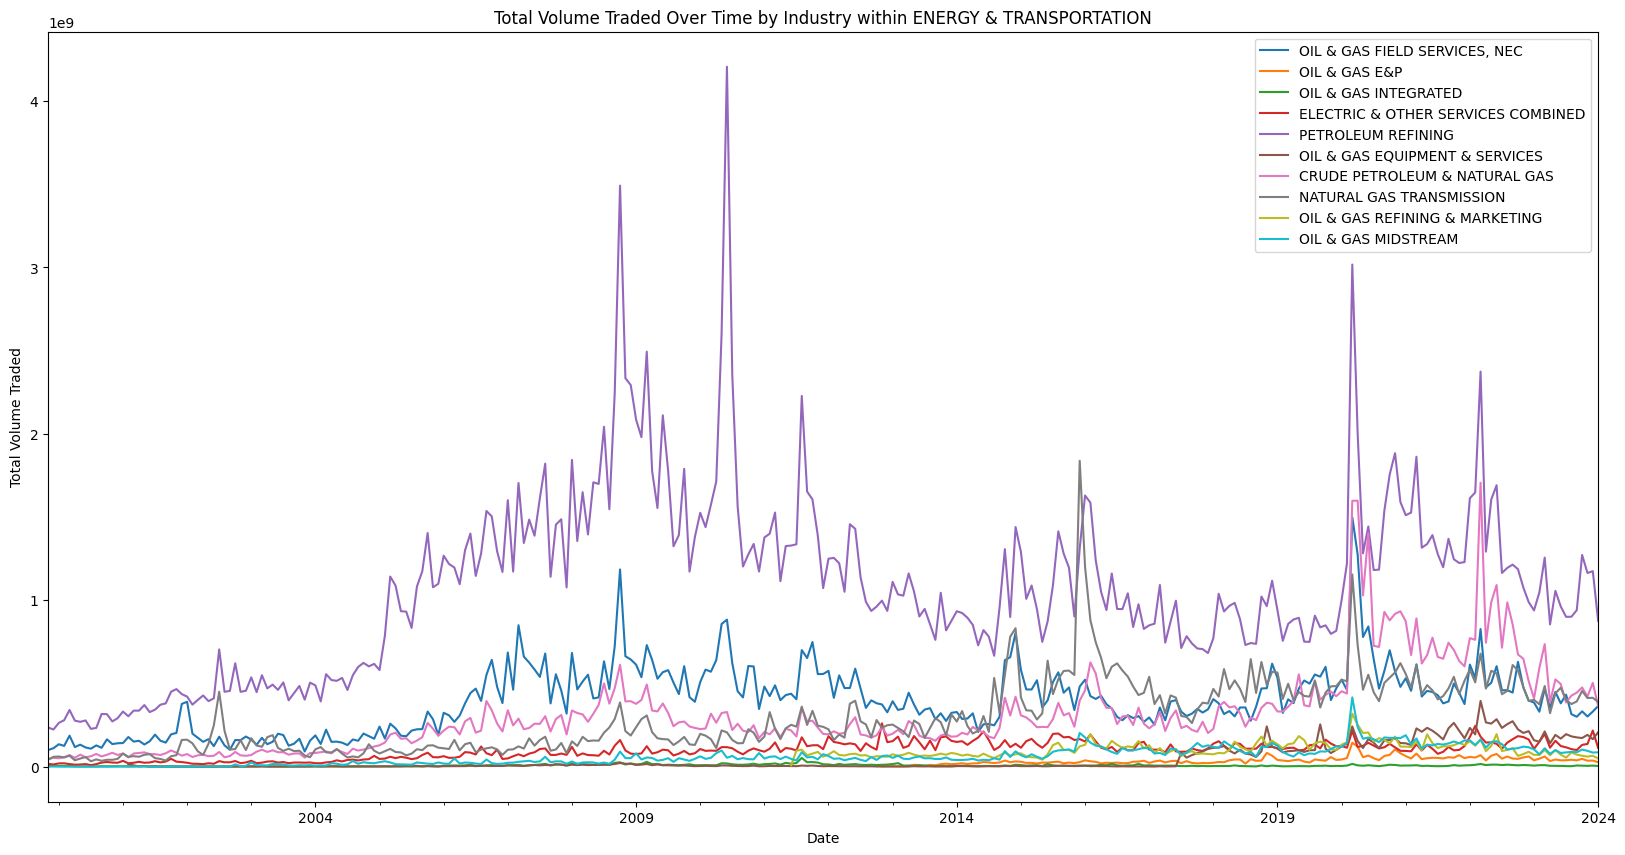

In [40]:
def plot_volume_by_industry_within_sector(data, sector_name):
    plt.figure(figsize=(20, 10))
    industry_data = data[data['Sector'] == sector_name]
    industries = industry_data['Industry'].unique()
    for industry in industries:
        industry_specific_data = industry_data[industry_data['Industry'] == industry]
        industry_specific_data.resample('M', on='Date-Time').sum()['Volume'].plot(label=industry)
    plt.title(f'Total Volume Traded Over Time by Industry within {sector_name}')
    plt.xlabel('Date')
    plt.ylabel('Total Volume Traded')
    plt.legend()
    plt.show()

plot_volume_by_industry_within_sector(stock_data, 'TECHNOLOGY')
plot_volume_by_industry_within_sector(stock_data, 'ENERGY & TRANSPORTATION')


<ipython-input-58-2ecf63684530>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date-Time'] = pd.to_datetime(data['Date-Time'])
<ipython-input-58-2ecf63684530>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
<ipython-input-58-2ecf63684530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

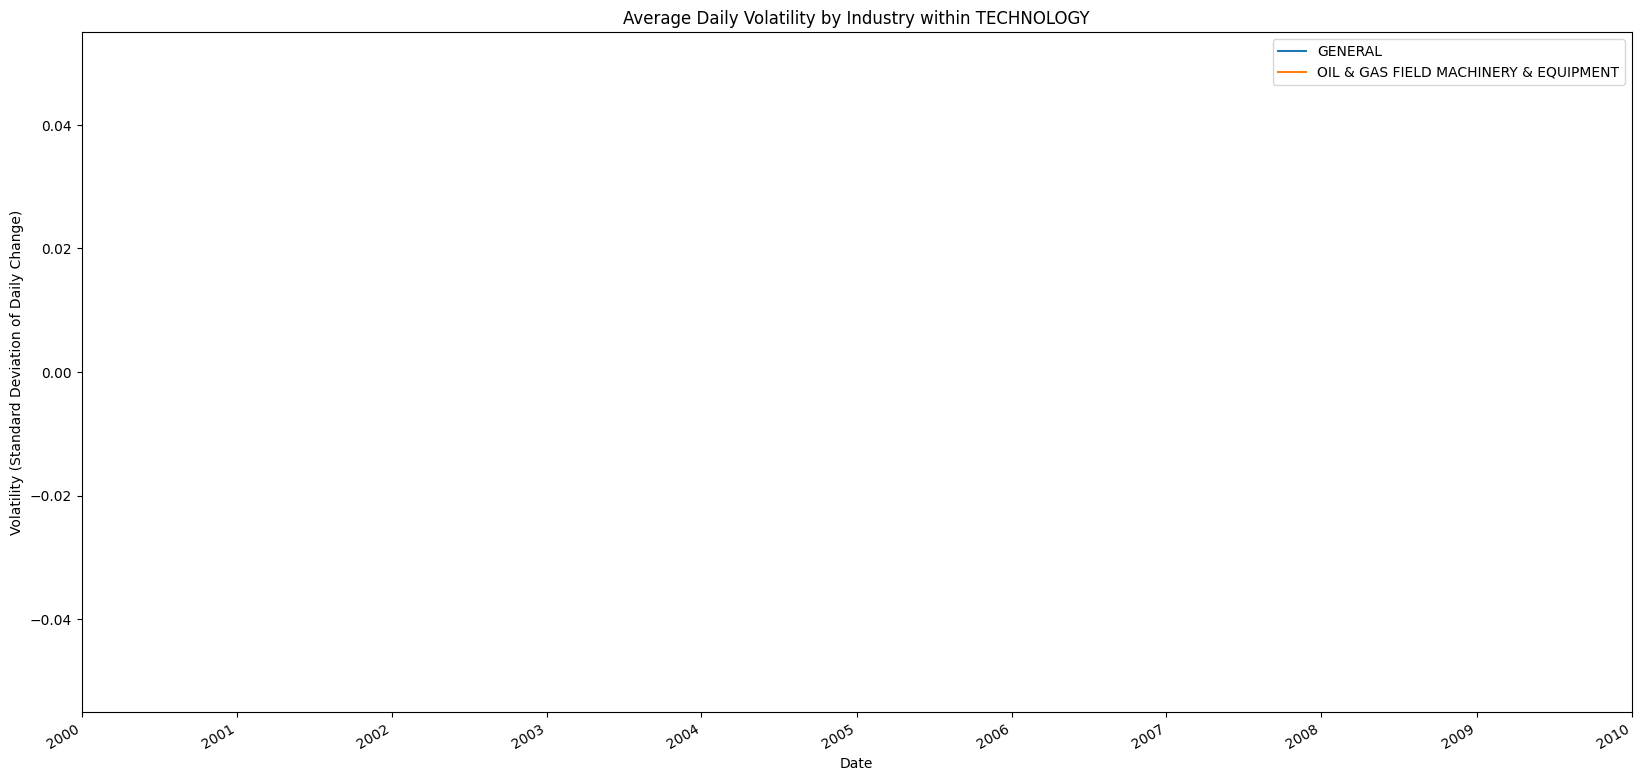

<ipython-input-58-2ecf63684530>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date-Time'] = pd.to_datetime(data['Date-Time'])
<ipython-input-58-2ecf63684530>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
<ipython-input-58-2ecf63684530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

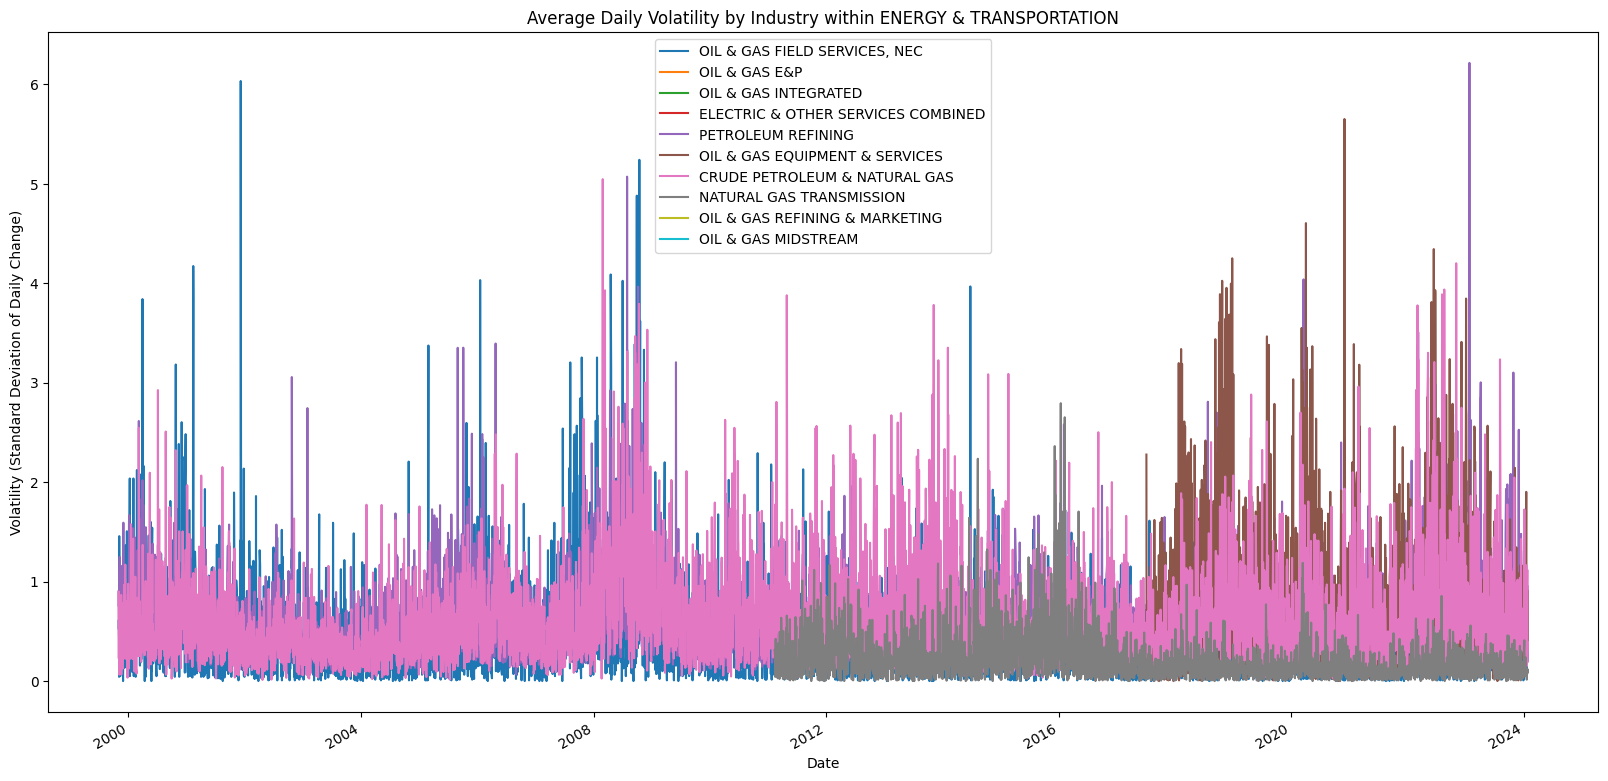

In [58]:
def plot_volatility_by_industry_within_sector(data, sector_name):
    plt.figure(figsize=(20, 10))
    # Ensure 'Date-Time' is of datetime type
    data['Date-Time'] = pd.to_datetime(data['Date-Time'])

    # Ensure 'Close' and 'Open' are numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    data['Open'] = pd.to_numeric(data['Open'], errors='coerce')

    # Calculate 'Daily Change' once for all
    data['Daily Change'] = data['Close'] - data['Open']

    industry_data = data[data['Sector'] == sector_name]
    industries = industry_data['Industry'].unique()

    for industry in industries:
        industry_specific_data = industry_data[industry_data['Industry'] == industry]

        # Calculate daily volatility within each industry
        daily_volatility = industry_specific_data.groupby('Date-Time')['Daily Change'].std()

        daily_volatility.plot(label=industry)

    plt.title(f'Average Daily Volatility by Industry within {sector_name}')
    plt.xlabel('Date')
    plt.ylabel('Volatility (Standard Deviation of Daily Change)')
    plt.legend()
    plt.show()


plot_volatility_by_industry_within_sector(stock_data, 'TECHNOLOGY')
plot_volatility_by_industry_within_sector(stock_data, 'ENERGY & TRANSPORTATION')


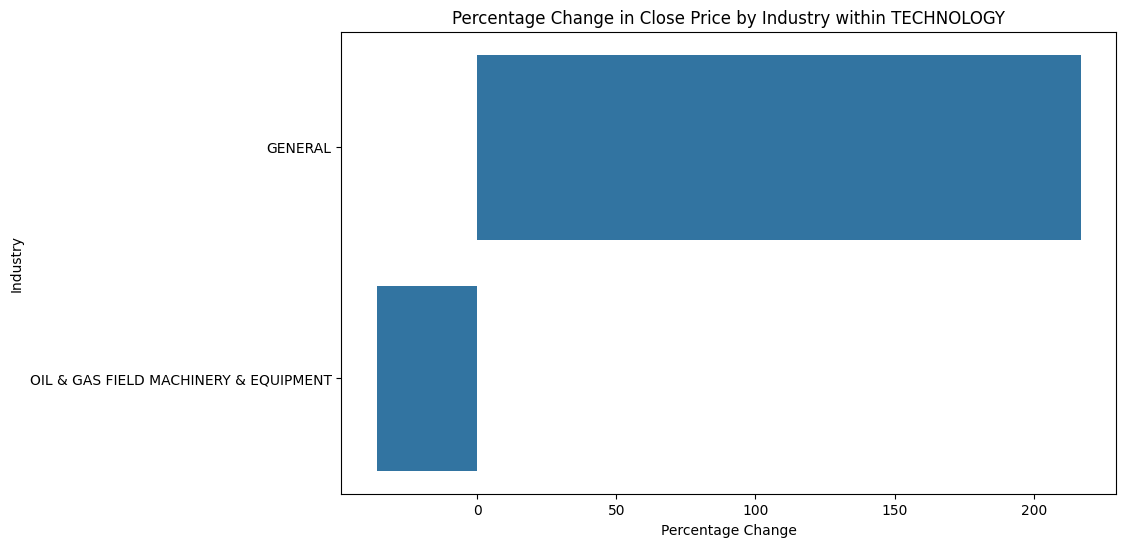

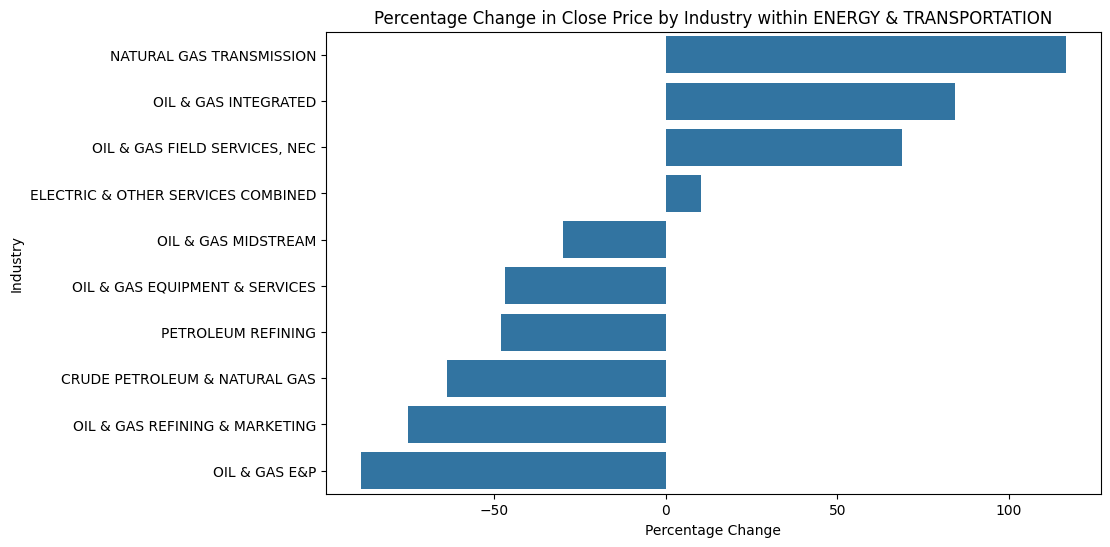

In [52]:
def compare_performance_by_industry_within_sector(data, sector_name):
    industry_data = data[data['Sector'] == sector_name]
    industries = industry_data['Industry'].unique()
    performance = {}
    for industry in industries:
        industry_specific_data = industry_data[industry_data['Industry'] == industry]
        initial_value = industry_specific_data.iloc[0]['Close']
        final_value = industry_specific_data.iloc[-1]['Close']
        performance[industry] = ((final_value - initial_value) / initial_value) * 100
    performance_df = pd.DataFrame(list(performance.items()), columns=['Industry', 'Percentage Change'])
    performance_df.sort_values('Percentage Change', inplace=True, ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Percentage Change', y='Industry', data=performance_df)
    plt.title(f'Percentage Change in Close Price by Industry within {sector_name}')
    plt.xlabel('Percentage Change')
    plt.ylabel('Industry')
    plt.show()

# Example usage
compare_performance_by_industry_within_sector(stock_data, 'TECHNOLOGY')
compare_performance_by_industry_within_sector(stock_data, 'ENERGY & TRANSPORTATION')


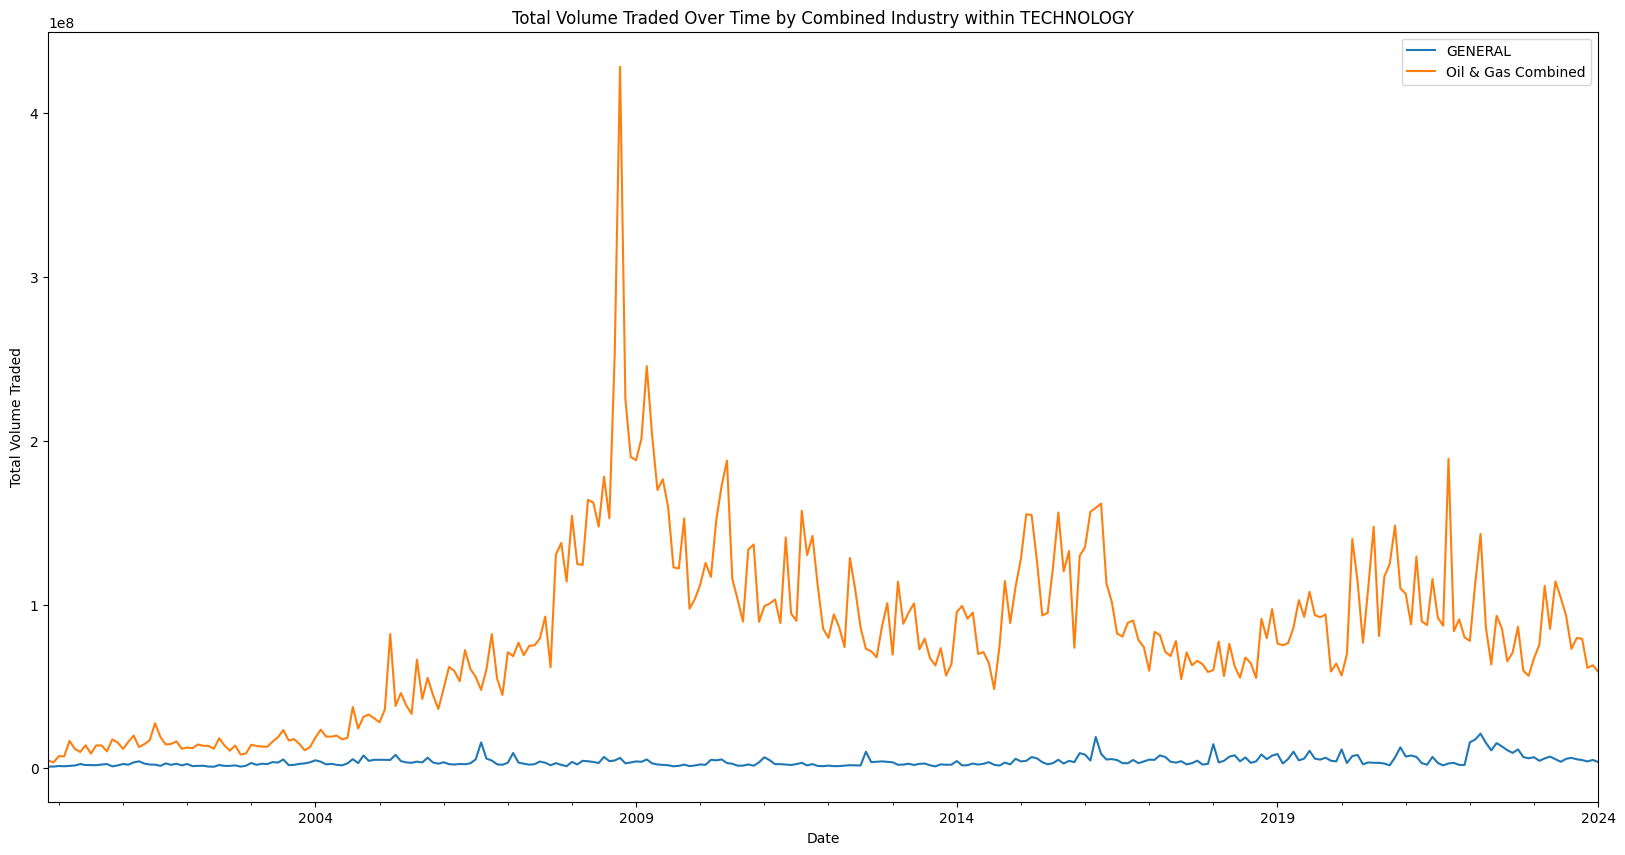

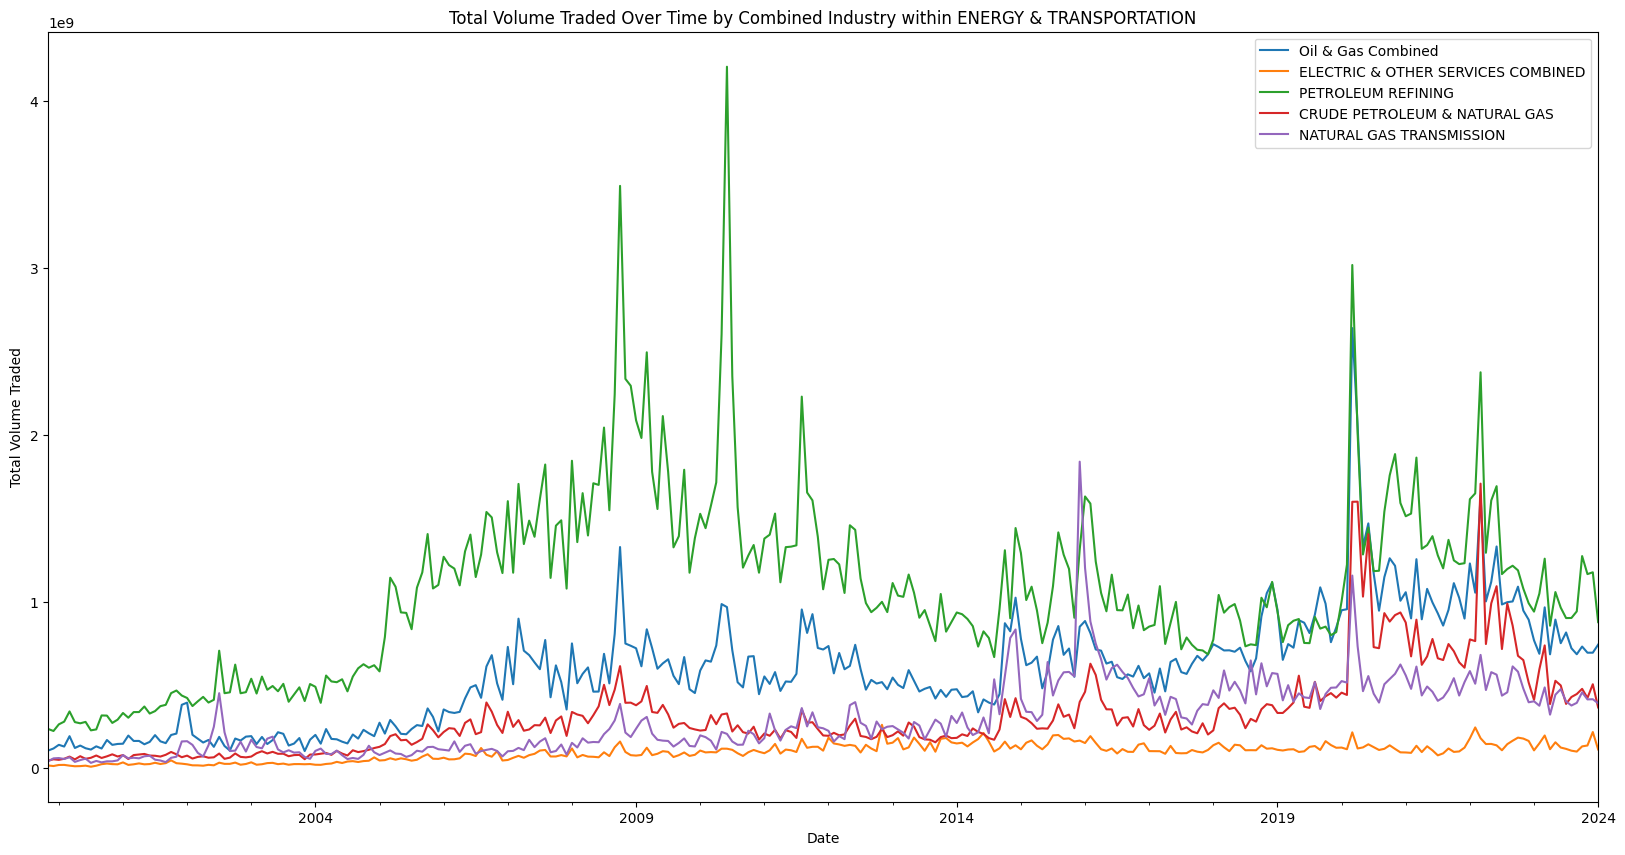

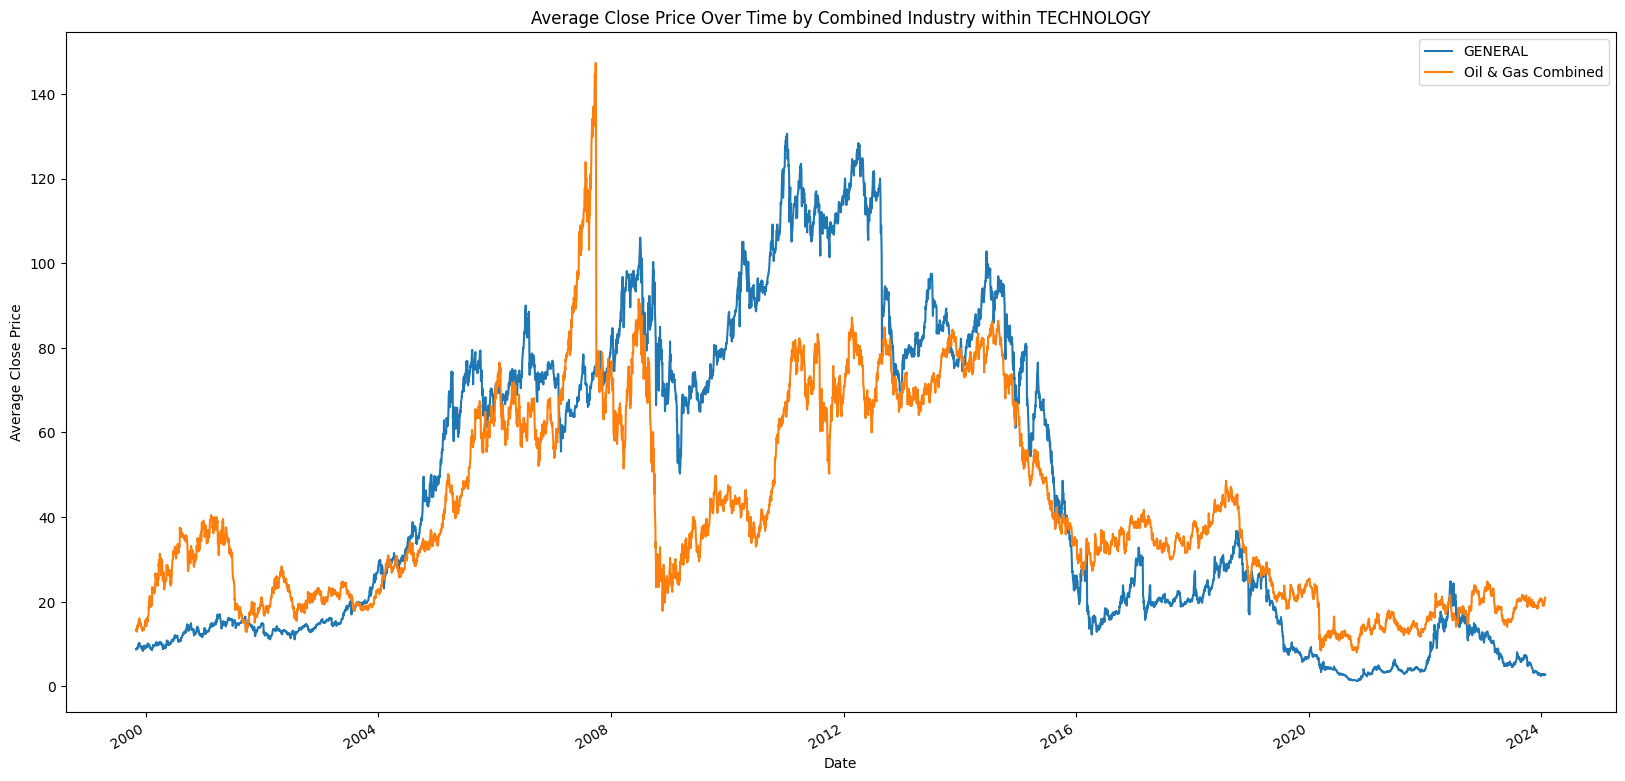

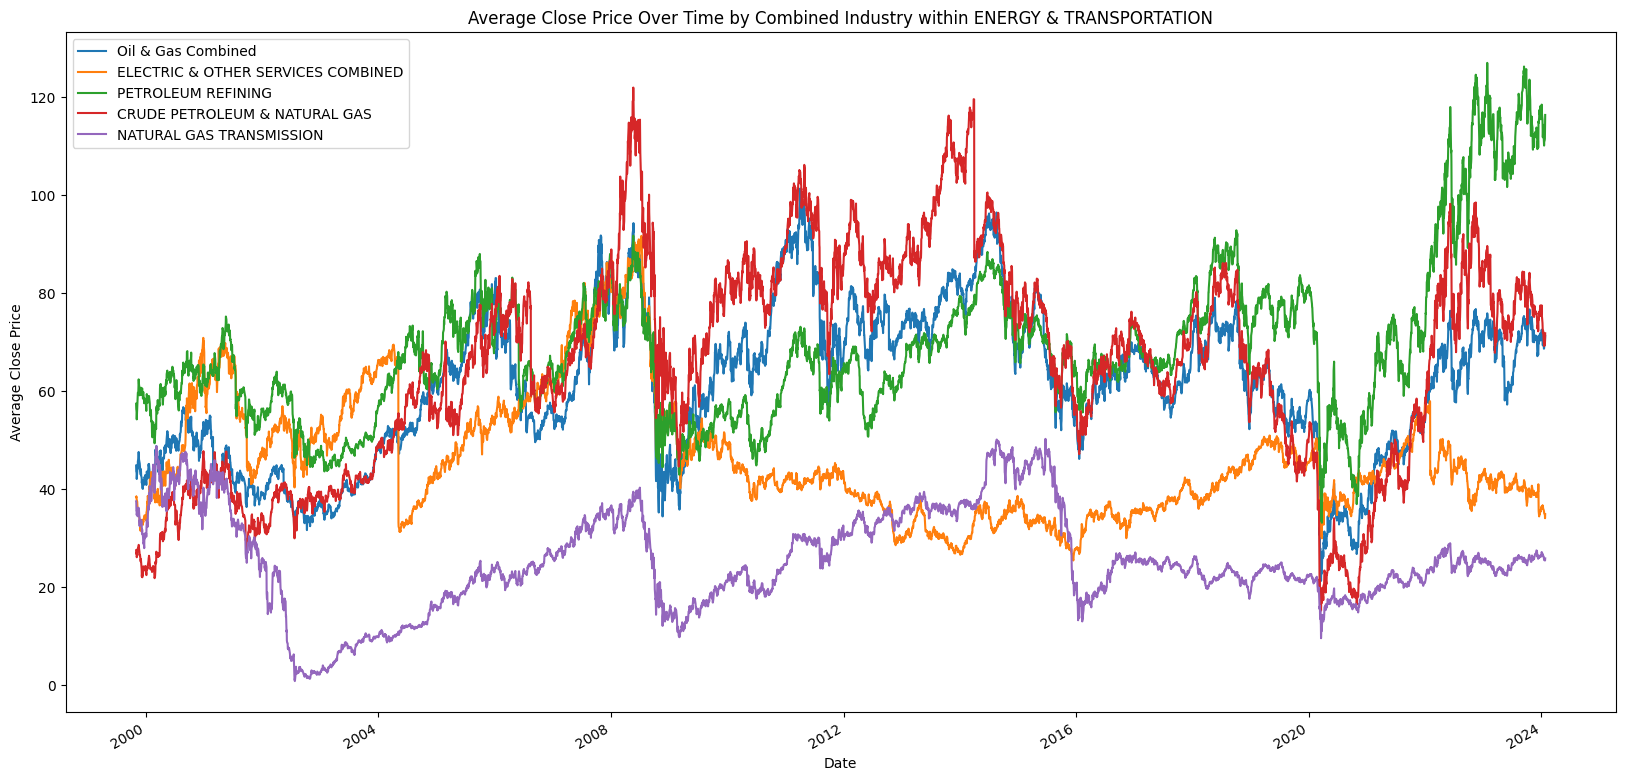

In [59]:
#combine all categories except electricity
def plot_volume_by_industry_within_sector_combined(data, sector_name):
    plt.figure(figsize=(20, 10))
    industry_data = data[(data['Sector'] == sector_name) & (data['AssetType'] != 'ETF')].copy()

    # Combine all Oil & Gas related industries into one category, excluding 'ELECTRIC & OTHER SERVICES COMBINED'
    industry_data['Industry Combined'] = industry_data['Industry'].replace(
        to_replace=r'^OIL & GAS.*', value='Oil & Gas Combined', regex=True)
    industry_data.loc[industry_data['Industry'] == 'ELECTRIC & OTHER SERVICES COMBINED', 'Industry Combined'] = 'ELECTRIC & OTHER SERVICES COMBINED'

    industries_combined = industry_data['Industry Combined'].unique()

    for industry in industries_combined:
        industry_specific_data = industry_data[industry_data['Industry Combined'] == industry]
        industry_specific_data.resample('M', on='Date-Time').sum()['Volume'].plot(label=industry)

    plt.title(f'Total Volume Traded Over Time by Combined Industry within {sector_name}')
    plt.xlabel('Date')
    plt.ylabel('Total Volume Traded')
    plt.legend()
    plt.show()

def plot_industry_trends_within_sector_combined(data, sector_name):
    plt.figure(figsize=(20, 10))
    industry_data = data[(data['Sector'] == sector_name) & (data['AssetType'] != 'ETF')].copy()

    # Same combination process as in volume analysis
    industry_data['Industry Combined'] = industry_data['Industry'].replace(
        to_replace=r'^OIL & GAS.*', value='Oil & Gas Combined', regex=True)
    industry_data.loc[industry_data['Industry'] == 'ELECTRIC & OTHER SERVICES COMBINED', 'Industry Combined'] = 'ELECTRIC & OTHER SERVICES COMBINED'

    industries_combined = industry_data['Industry Combined'].unique()

    for industry in industries_combined:
        industry_specific_data = industry_data[industry_data['Industry Combined'] == industry]
        industry_specific_data.groupby('Date-Time')['Close'].mean().plot(label=industry)

    plt.title(f'Average Close Price Over Time by Combined Industry within {sector_name}')
    plt.xlabel('Date')
    plt.ylabel('Average Close Price')
    plt.legend()
    plt.show()

# Now, you can call these functions for the 'TECHNOLOGY' and 'ENERGY & TRANSPORTATION' sectors
plot_volume_by_industry_within_sector_combined(stock_data, 'TECHNOLOGY')
plot_volume_by_industry_within_sector_combined(stock_data, 'ENERGY & TRANSPORTATION')
plot_industry_trends_within_sector_combined(stock_data, 'TECHNOLOGY')
plot_industry_trends_within_sector_combined(stock_data, 'ENERGY & TRANSPORTATION')

